# Individual and Comparative Analysis of Pop, Hip Hop, and Rock Song Structures

## Motivation for Project
Songwriting is oftentimes formulaic in some respects, particularly in terms of the overall structure. There are in theory infinitely many structures that a song can have even from 2 different substructures like Verse and Chorus (V-C, C-V, C-C-C, etc.) With that being said, only a relatively small proportion of these structures are observed even with as many as 6 or 7 general structural components to choose from. It is in the best interest of a beginner songwriter to select song structures that are common within their desired genre, but to also have a variety of structures so to add variety to their musical repetoire. 

Even once a general song structure has been identified, it is important to also work within the constraints of that particular genre/structure's norms with respect to how many words and lines are in that structure. If a song's verse has 100 lines before it reaches a 4 line chorus, it will likely not be successful. It may also be the case that there are differences between having something like 3 or 4 lines in a verse. With that being said, it is also important for beginner songwriters to have an idea of how many lines their songs should have in each component. 

For the non-songwriter, their interest in this work may be in the final section where there is a comparative analysis between the three genres with respect to various statistics describing song structure features, such as number of words/lines or average length of words. 

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import os.path
from os import path
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
from scipy.stats import t
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import svm

# Data Acquisition
The first section will acquire genius song lyrics data from selected artists in differenet genres. Genius returns the songs in order of popularity on their website, which may be different from how the songs performed on Billboard charts. The number of times a song gets searched on Genius is likely highly correlated with general song popularity, which is likely highly correlated with Billboard rankings along with personal fanbase preferences. 30 Songs from each artist are identified as well, so it is very likely that the artist's big hits will be within the top 30 search on Genius along with some fan favorites. As such, using Genius' own popularity rankings are likely a fairly good representation of a particular artist's notable repetoire.

The website is linked here where top songs any artist can be searched: https://genius.com/

#### Functions Citation

The following 4 functions are slightly modified versions of the functions found at the below website that gives an introduction to scraping genius web lyrics. The modifications I made change how they store the songs (i.e. storing song structure and appending titles). These functions will be used to store the song lyrics for selected artists in a local directory for further analysis.
https://medium.com/analytics-vidhya/how-to-scrape-song-lyrics-a-gentle-python-tutorial-5b1d4ab351d2

In [2]:
# Get artist object from Genius API
GENIUS_API_TOKEN = 'TifFNgZ-aWrI7msPryTVsi1R0P6mWHKzbuZ0S38psQfuZp-0XLRskXbg8Femhz7n'

# This function returns a response that is parseable into json for a given artist
def request_artist_info(artist_name, page):
    base_url = 'https://api.genius.com'
    headers = {'Authorization': 'Bearer ' + GENIUS_API_TOKEN}
    search_url = base_url + '/search?per_page=10&page=' + str(page)
    data = {'q': artist_name}
    response = requests.get(search_url, data=data, headers=headers)
    return response

# Get Genius.com song url's from artist object. It gets the number of songs in song_cap if there are that many
# availabkle. Note this also includes songs where the artist is only featured
def request_song_url(artist_name, song_cap):
    page = 1
    songs = []
    
    while True:
        response = request_artist_info(artist_name, page)
        json = response.json()
        # Collect up to song_cap song objects from artist
        song_info = []
        for hit in json['response']['hits']:
            if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
                song_info.append(hit)
    
        # Collect song URL's from song objects
        for song in song_info:
            if (len(songs) < song_cap):
                url = song['result']['url']
                songs.append(url)
            
        if (len(songs) == song_cap):
            break
        else:
            page += 1
        
    print('Found {} songs by {}'.format(len(songs), artist_name))
    return songs
    
# Scrape lyrics from a Genius.com song URL for a particular song
def scrape_song_lyrics(url):
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    title = '<TITLE>' + url.split('/')[3].replace('-lyrics','\n')
    lyrics = title + html.find('div', class_='lyrics').get_text()
    lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])
    return (lyrics)

# writes all of the lyrics found for an artist into a file. The lyrics directory must be premade, but the files do not
def write_lyrics_to_file(artist_name, song_count):
    f = open('lyrics/' + artist_name.lower().replace(" ", "") + '.txt', 'wb')
    urls = request_song_url(artist_name, song_count)
    for url in urls:
        # Appends <END> at the end of every song for later parseing
        lyrics = scrape_song_lyrics(url) + '<END>'
        f.write(lyrics.encode("utf8"))
    f.close()
    num_lines = sum(1 for line in open('lyrics/' + artist_name.lower().replace(" ", "") + '.txt', 'rb'))
    print('Wrote {} lines to file from {} songs'.format(num_lines, song_count))

## Artist Lists
The Below are the artists that I will be using in my analysis. These artists were subjectively selected by me using a combination of personal preference and perceived popularity. There are 7 artists in each category and analysis is typically performed combining male and female categories of the same genre.

In [3]:
artists = {'fem_pop':['Ariana Grande','Katy Perry','Lady Gaga','Taylor Swift','Britney Spears',\
                     'Kesha','Kelly Clarkson'],\
           'male_pop':['Justin Bieber','Shawn Mendes','Ed Sheeran','One Direction','OneRepublic',\
                       'Maroon 5','Justin Timberlake'],\
            'male_hiphop':['Drake','Kanye West','Lil Wayne','DaBaby','J. Cole','Kendrick Lamar','Eminem'],\
            'fem_hiphop':['Nicki Minaj','Doja Cat','Azealia Banks','cupcakKe','Megan Thee Stallion','Cardi B',\
                         'Iggy Azalea'],\
              'male_rock':['The Beatles','Queen','Pink Floyd','Nirvana','Red Hot Chili Peppers',\
                           'Pearl Jam','Catfish and the Bottlemen']}


## Aquiring Lyrics Data
The create_path function will be used to retrieve the path name for a given artist's lyrics file. For example, if you want the path of Nicki Minaj, the function will return "lyrics/nickiminaj.txt" which can then be read and worked with as a file.

The piece of code after the function is used to scrape the lyrics for all of the artists in the dictionary of artists made in the cell before. It uses the predefined functions for scraping the genius URL's and scrapes at most 30 songs from genius. This entire process can take around 10 minutes when done from scratch, but if there already exits a .txt file corresponding to the artist's name (as in you already have their lyrics), it will not scrape again and will print a statement letting you know how many lines were scraped.
##### Make sure to look at the number of lines in each file so that it seems reasonable. If any files have less than several hundred lines, there may be an issue

In [4]:
def create_path(name):
    return str('lyrics/'+name.lower().replace(" ", "") +'.txt')

for names in artists.values():
    for name in names:
        name_path = create_path(name)
        if path.exists(name_path):
            f = open(create_path(name))
            count = len(f.readlines(  ))
            print(name,'has',count,'lines in the .txt file')
            f.close()
        else:
            write_lyrics_to_file(name,30)

Ariana Grande has 1967 lines in the .txt file
Katy Perry has 2099 lines in the .txt file
Lady Gaga has 2091 lines in the .txt file
Taylor Swift has 1866 lines in the .txt file
Britney Spears has 2046 lines in the .txt file
Kesha has 1927 lines in the .txt file
Kelly Clarkson has 1816 lines in the .txt file
Justin Bieber has 1818 lines in the .txt file
Shawn Mendes has 1680 lines in the .txt file
Ed Sheeran has 2019 lines in the .txt file
One Direction has 1529 lines in the .txt file
OneRepublic has 1666 lines in the .txt file
Maroon 5 has 2012 lines in the .txt file
Justin Timberlake has 2756 lines in the .txt file
Drake has 2407 lines in the .txt file
Kanye West has 2573 lines in the .txt file
Lil Wayne has 2594 lines in the .txt file
DaBaby has 2335 lines in the .txt file
J. Cole has 2955 lines in the .txt file
Kendrick Lamar has 3374 lines in the .txt file
Eminem has 3468 lines in the .txt file
Nicki Minaj has 2550 lines in the .txt file
Doja Cat has 2213 lines in the .txt file
Azea

# Data Processing
This section defines 3 classes and many functions pertaining to these classes that will be used for storing an artists songs and each song's general structure. Examples of structure objects are things like "Verse" or "Chorus" and each song is made up of a variety of differnet substructures, giving each song an overall general structure. An example of a general structure for a song would be something like "Verse Chorus Verse Chorus Outro." The classes have functionality to calculate a number of statistics about a particular structure, such as the number of words, number of lines, number of repeat words/lines, and other metrics. One thing to note is that not all of the methods or data stored are used in this tutorial (such as whether or not a verse is a feature), but could instead be used for future analysis.

For more information about specific song structures, visit this genius link:
https://genius.com/Genius-song-parts-annotated

### Artist class
The Artist class is made to store an artist's name and their songs. Objects of this class are instantiated using their name. It is important that the name is spelled correctly or  the artists songs will not get added because the parse_text method does not add songs to an Artist object if the artist in question was not the main artist (i.e. was featured) and  determines whether or not the artist was the main artist or feature artist by matching  between the artist name and the first name of the genius url link after the .com, which is stored in the first line (and includes the title) of each individual song (as separated by '\<TITLE\>' and \<END\>"

In [5]:
class Artist:
    
    def __init__(self, name, category):
        self.name = name
        self.songs = []
        self.category = category

    # This method will store all of the songs of an artist in a list
    # This method should called with the raw text that is stored in the files directly from genius scraping
    def parse_text(self, text):
        for song_text in text.split('<TITLE>')[1:]: # the first one is always an empty string
            
            # This checks to see if the artist was actually just featured on the song, in 
            # which case it is exluded from their data
            length = len(self.name)
            title_artist = song_text[0:length].lower()
            
            # the strip at the end is for J. Cole because the URL did not include the '.'
            first_name = self.name[0:self.name.find(' ')].lower().strip('\.')
            
            # The first if statement makes sure the artist did not simply feature on the song, which is determined 
            # by the first name on the URL, which is stored in the first line of each song's txt within the file
            if title_artist[0:len(first_name)] == first_name:
                song = Song(self.name)
                song.parse_song(song_text.replace('<END>','\n'))
                
                # makes sure the song has structural components
                if not song.get_gen_struct() == '':
                    self.songs.append(song)

    def num_songs(self):
        return len(self.songs)
    
    # This returns all of the lines of every song as a list
    def get_lines(self):
        lines = []
        for song in self.songs:
            for struct in song.structure:
                for line in struct.lines:
                    lines.append(line)
                    
        return lines

### Song class
The song class creates Song objects that store the name of the artist, the title of the song and the overal structure of the song, which uses structure objects that denote the type of structure and store all of the lines of that part of the song

In [6]:
# this pattern will match anything that has 1 or more characters within square brackets
# which includes all of the structural components of the songs like [Chorus] or [Bridge]
struct_regex = re.compile('\[(.+)\]')

class Song:
    def __init__(self, artist_name):
        self.artist = artist_name
        self.title = ''
        self.structure = []

    # This method will store all of the song's structure objects in a list. Structure objects include the lyrics for 
    # that structure
    # This method should called with the text of a single song with the title from the URL as the first line
    def parse_song(self, song_text):
        
        # All structures genius returns are stored in brackets like [Chorus]
        body = re.split('\[', song_text)
        
        # Title includes artist name as well and is separated by '-' instead of spaces (it comes from the URL)
        self.title = body[0].split('\n')[0]
        
        # raw_struct are the lines beginning with something like [Chorus]\nFirst lines\nNext line\nso on
        for raw_struct in body[1:]:
            clean_struct = Struct()
            clean_struct.parse_struct(raw_struct, self.artist)
            
            if not len(clean_struct.lines) == 0:
                self.structure.append(clean_struct)

    # Does not include the following structures: Other, Outro, Refrain. Only want general structure
    # returns a string separated by spaces
    def get_gen_struct(self):
        type_list = []
        for struct in self.structure:
            s_type = struct.type
            if not (s_type == 'Other' or s_type == 'Refrain' or s_type == 'Outro'):
                type_list.append(struct.type)
        
        return " ".join(type_list)
    
    # returns the lines of a song as a list of strings
    def get_lines(self):
        lines = []
        for struct in self.structure:
            for line in struct.lines:
                lines.append(line)
                    
        return lines
    
    # returns only the lines that are not repeated
    def get_unique_lines(self):
        lines = self.get_lines()
        return list(np.unique(lines))

### Structure class
This class creates Struct objects that store the type of song structure component, such as verse or chorus, and also stores whether or not that component was written by a featured artist rather than the original artist of the song. This class addiiontally stores all of the lines for its corresponding part in the song and has methods for calculating a number of statistics pertaining to the structure.

In [7]:
struct_types = ['Intro','Verse','Chorus','Bridge','Pre-Chorus','Post-Chorus','Outro',\
                'Refrain','Instrumental','Solo','Other']

class Struct:
    def __init__(self):
        self.type = 'Other'
        self.feature = False
        self.lines = []
        
    # This should be called 
    def parse_struct(self, struct_text, artist_name):
        split_text = struct_text.split('\n')
        
        # split_text[0] = something like 'Chorus 1: (...)]'
        type_text = split_text[0] 
        
        # This corrects spelling mistake of "Chrous" that was found in several files
        if 'Chrous' in type_text:
            type_text = type_text.replace('Chrous','Chorus')
        
        # Genius updated its terminology at one point to make "hook" -> "chorus"
        if 'Hook' in type_text:
            type_text = type_text.replace('Hook','Chorus')

        # checks to see if first word within the bracketed structure in the text file is one of the predefined
        # structure types. If not, the type is defauled to "Other"
        for s_type in struct_types: 
            if s_type in type_text:
                self.type = s_type
                
        # Colors in the structure name indicate a feature, but can also indicate a duet. In instances where it is 
        # a duet, the structure is not stored as a feature
        if ':' in type_text:
            # will make Verse 1: Ariana Grande & Britney spears -> ' Ariana Grande & ...'
            cut_line = type_text[type_text.find(':')+1:]
            
            # This determines if the artist's name comes first, which could mean it is a duet or something where the
            # artist is still a main vocalist (and therefore not being considered a feature structure)
            if artist_name in cut_line:
                # if the artist's name is in the line and first, this will be true. If not, it will be false
                self.feature = len(cut_line) > len(artist_name) + 2
            else:
                self.feature = True
        
        self.lines = split_text[1:-1] # skips the type and the last new line
        
    # This returns words cleaned to remove any punctuation and capitalization to be used for determining uniqueness
    def get_clean_words(self):
        words = []
        for line in self.lines:
            for word in line.split():
                clean_word = word.translate(str.maketrans('', '', string.punctuation)).lower()
                words.append(clean_word)
    
        return words
    
    # number of lines in the structure
    def get_num_lines(self):
        return len(self.lines)
    
    # number of words in the structure
    def get_num_words(self):
        word_count = 0
        for line in self.lines:
            word_count += len(line.split())
        
        return word_count
    
    # number of repeated words in the structure
    def get_num_repeat_words(self):
        words = self.get_clean_words()
        return len(words) - len(list(np.unique(words)))
    
    # number of repeated lines in the structure
    def get_num_repeat_lines(self):
        return self.get_num_lines() - len(list(np.unique(self.lines)))
    
    # returns the average words per line in the structure
    def get_wpl(self):
        return self.get_num_words()/self.get_num_lines()
    
    # returns the standard deviation of # words across lines
    def get_std_wpl(self):
        words = []
        for line in self.lines:
            words.append(len(line.split()))
    
        return np.std(words)
    
    # returns the mean length of words in the structure
    def get_mean_word_len(self):
        words = self.get_clean_words()
        w_lengths = []
        for word in words:
            w_lengths.append(len(word))
            
        return np.mean(w_lengths)
    
    # returns the standard deviatoin of word length across the structure
    def get_std_word_len(self):
        words = self.get_clean_words()
        w_lengths = []
        for word in words:
            w_lengths.append(len(word))
            
        return np.std(w_lengths)
    
    # returns a list of statistics describing the structure which is later used for machine learning classification
    def get_full_analysis(self):
        return [self.get_num_words(),\
                self.get_num_lines(),\
                self.get_num_repeat_words(),\
                self.get_num_repeat_lines(),\
                self.get_std_wpl(),\
                self.get_mean_word_len(),\
                self.get_std_word_len()]
        

# Data Analysis
This section will look into the most common general song structures in across the different genres (pop, hiphop, rock). It does this individually for each genre and visualizes both the top structures and a breakdown of the distribution of words and lines within each structure. The exact same analysis is performed for each of the three genres with predefined functions. The individual analysis would be useful for songwriters who want to see how well their structures fit into the norms within the genre.

### The following 3 functions are used to retrieve general structures from selected artists.
In the code these functions are used to determine common general structures within genres
Note general structures were previously defined in the class section to omit structures that were stored as "Other","Outro", or "Refrain"

In [8]:
# this returns a list of all general structures from all artists within the list. 
def get_all_structs(all_artists):
    all_structs = []

    for artist in all_artists:
        for song in artist.songs:
            all_structs.append(song.get_gen_struct())
    
    return all_structs

# Returns a dictionary storing all unique general structures along mapped to how many times they appeared within the
# songs of the list of artists passed in
def get_struct_count(all_artists):
    total_structs = get_all_structs(all_artists)

    uniq_structs = np.unique(total_structs)

    struct_count = {}
    for struct in uniq_structs:
        struct_count[struct] = 0

    for struct in total_structs:
        struct_count[struct] += 1
    
    return struct_count

# Returns a dictionary of the structures that appeared at least threshold times within all of the songs of all artists
# passed in
def get_top_thresh_structs(all_artists,threshold):
    s_counts = get_struct_count(all_artists)
    top_thresh_structs = {}
    
    for key,val in s_counts.items():
        if val >= threshold:
            top_thresh_structs[key] = val
    
    return top_thresh_structs

### Structural Pie Chart
This function generates a pie chart of all the general structures that had a frequency of at least 'threshold' of all songs of all artists passed in. The pie chart uses percentages that are relative to eachother in the threshold, not to all general structures. This is used to see the top structures which someone can select from for songwriting. The function also prints out the structures and their frequencies.

In [9]:
def create_top_thresh_structs_pie(all_artists, threshold):
    t_structs = get_top_thresh_structs(all_artists, threshold)

    print('The structures that were used at least', threshold,'times were the following:')
    pprint.pprint(get_top_thresh_structs(all_artists,threshold))
    
    struct_labels = {}
    labeled_t_structs = {}
    for i, struct in enumerate(t_structs.keys()):
        struct_labels[struct] = i
        labeled_t_structs[i] = t_structs[struct]
    
    fig1, ax1 = plt.subplots()
    ax1.pie(t_structs.values(), labels=t_structs.keys(), autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

### Words Per Line (wpl) and Lines Per Structure (lps)
The following functions return dictionaries whose keys are general structure types and whose values are lists of the desired statistic calculated for all target structures in all songs of all artists passed in. This is used to later to investigate difference between structural components on average with respect to wpl or lps

In [10]:
# returns dictionary with all target structures and a list of words per line in all of those structures found within
# songs within the artists passed in
def get_wpl(artists, target_structs):
    wpl = {}
    for s_type in target_structs:
        wpl[s_type] = []
    
    for artist in artists:
        for song in artist.songs:
            for struct in song.structure:
                s_type = struct.type
                if s_type in target_structs:
                    wpl[struct.type].append(struct.get_wpl())
                    
    return wpl
         
# returns dictionary with all target structures and a list of lines per structure in all of those structures found 
# within songs within the artists passed in
def get_lps(artists, target_structs):
    lps = {}
    for s_type in target_structs:
        lps[s_type] = []
        
    for artist in artists:
        for song in artist.songs:
            for struct in song.structure:
                s_type = struct.type
                if s_type in target_structs:
                    lps[struct.type].append(len(struct.lines))
                    
    return lps

### Create boxplots and mean_ttest
These two functions are used to visualize differneces between statistics of structures and to determine whether or not the mean value of those statistics differ between structures in a statistically significant way. 

In [11]:
# Takes in dictionary mapping structures to a list of values of a particular statistic and generates a boxplot with
# each structure's distributions show
def create_boxplots(struct_dict):
    fig, ax = plt.subplots()
    ax.boxplot(struct_dict.values(), showfliers = False)
    ax.set_xticklabels(struct_dict.keys())
    
# This function prints out a description of the results of analysis
# takes in a dictionary's mapping and a list of target_structures to analyze and does statistical mean t-tests for all
# pairwise of combinations of the structures in the dictionary. The p-value used for accepting or rejecting the
# null hypothesis of identical population means is 0.05
def mean_ttest(struct_dict, target_structs):
    any_fails = False
    for i in range(len(target_structs)):
        for j in range(i+1, len(target_structs)):
            struct1 = target_structs[i]
            struct2 = target_structs[j]
            
            pval = stats.ttest_ind(struct_dict[struct1],struct_dict[struct2]).pvalue
            if pval >= 0.05:
                print(struct1,'vs',struct2,'pval=',pval,'which is above 0.05 ->',\
                     'fail to reject the null hypothesis\n')
                any_fails = True
                
    if any_fails:
        print('For all other combinations, the pvalue was less than 0.05, which is evidence to reject',\
              'the null hypothesis, meaning the difference in mean value between them was statistically signifcant')
    else:
        print('For all combinations, the pvalue was less than 0.05, which means the',\
             'the differnce between means for all categories was statistically signifcant.')
        

### Create histplots
This code is similar to the create_boxplots function above, but creates histograms for each individual structure rather than boxplots for all of the structures on a single plot. This is useful to look and see how specific numbers of lines/words per song structure are more common than others (just using a sample mean or median would not tell you this information). This could be very consequential because the sample mean lines in of pop verses could be 7 but no songs actually have 7 lines per verse, only 6 or 8

In [12]:
def create_histplots(struct_dict):
    for key, val in struct_dict.items():
        plot_range = (1,min(np.max(val),18))
        bins = range(1,plot_range[1]-plot_range[0]+1)
        plt.hist(val, range = plot_range, bins = bins)
        plt.xticks(bins)
        plt.title(key)
        plt.show()

### All Artists
The following code creates artist objects and parses their lyrics into songs/structures for all previously selected artists

In [13]:
artist_types = {'fem_pop':[],'male_pop':[],'male_hiphop':[],'fem_hiphop':[],'male_rock':[]}
for category in artists.keys():
    names = artists[category]
    for name in names:
        path = create_path(name)
    
        with open(path, 'r') as file:
            text = file.read()
            artist = Artist(name,category)
            artist.parse_text(text)
        
        file.close()
        
        artist_types[category].append(artist)

# Individual Genre Analysis
This information would be useful to someone who wants to try writing songs in one of the selected genres. The general approach I would recommend to someone interest in this would be to first look at the pie chart to see what type of structure they would like to try using (if no experience before, may as well choose the most popular). From there try writing some lyrics, but make sure they stay within the ranges of lines per structure/words per structure as shown in the boxplots. To refine the lyrics, take a look at the histograms that show the distribution of # of lines in each structure and try to choose a common number of lines. For example, pop choruses tend to have either 4 or 8 lines as shown in the histogram. This may mean altering the lyrics to get a more desired structure, but this likely is a good thing. As some famous painter once said, a true artist should be able to draw grapes so realistic that birds try to eat them before diving off into the abstract.

## Pop  Analysis
The following code performs analysis on pop artist structures to determine which is the most common using the previously described pie chart function as well as looking into the distribution of number of words/lines in each general structure type across pop songs. See the writing under the previous "Individual Analysis" section for how to go about using this information for songwriting

The structures that were used at least 8 times were the following:
{'Chorus Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus Bridge Chorus': 9,
 'Intro Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus Bridge Chorus': 23,
 'Verse Chorus Verse Chorus': 9,
 'Verse Chorus Verse Chorus Bridge Chorus': 50,
 'Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus': 9,
 'Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus Bridge Chorus': 77}


<function matplotlib.pyplot.show(*args, **kw)>

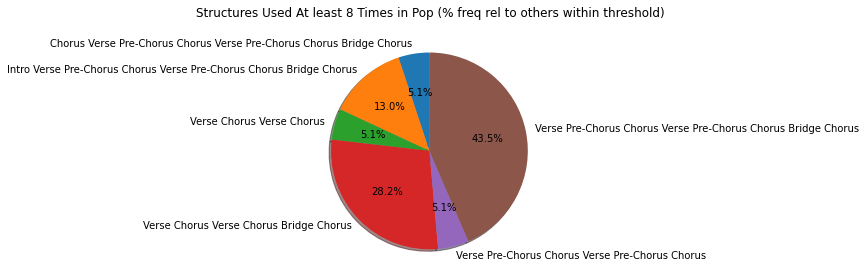

In [14]:
pop = artist_types['male_pop'] + artist_types['fem_pop']

threshold = 8
create_top_thresh_structs_pie(pop,threshold)
title = str('Structures Used At least '+str(threshold)+' Times in Pop (% freq rel to others within threshold)')
plt.title(title,pad= 25.5)
plt.show

In [15]:
target_structs = ['Intro','Chorus','Verse','Bridge','Pre-Chorus','Post-Chorus']
# words per line
pop_wpl = get_wpl(pop,target_structs) 
# lines per structure
pop_lps = get_lps(pop,target_structs)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


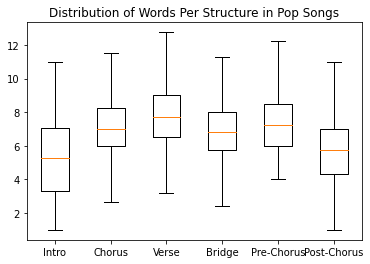

Intro vs Post-Chorus pval= 0.6768014487707718 which is above 0.05 -> fail to reject the null hypothesis

Chorus vs Bridge pval= 0.33615895577212584 which is above 0.05 -> fail to reject the null hypothesis

For all other combinations, the pvalue was less than 0.05, which is evidence to reject the null hypothesis, meaning the difference in mean value between them was statistically signifcant


In [16]:
create_boxplots(pop_wpl)
plt.title('Distribution of Words Per Structure in Pop Songs')
plt.show()

mean_ttest(pop_wpl, target_structs)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


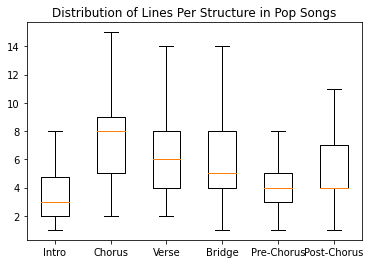

For all combinations, the pvalue was less than 0.05, which means the the differnce between means for all categories was statistically signifcant.


In [17]:
create_boxplots(pop_lps)
plt.title('Distribution of Lines Per Structure in Pop Songs')
plt.show()

mean_ttest(pop_lps, target_structs)

### Pop Lines Per Structure
The graphs below show that pop chrouses, verses, and bridges commonly have 4 or 8 lines while. the other structures (except for intro) most commonly have 4 lines. For intial songwriting, it would be adivsed to choose lines within these numbers

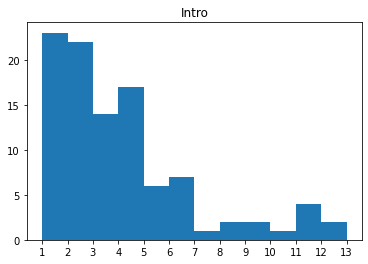

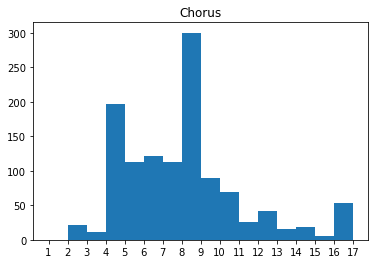

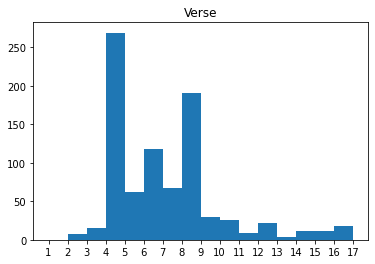

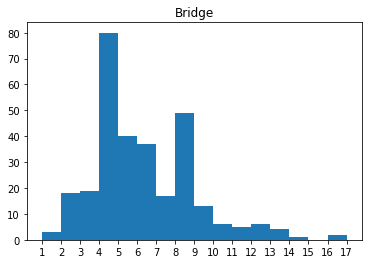

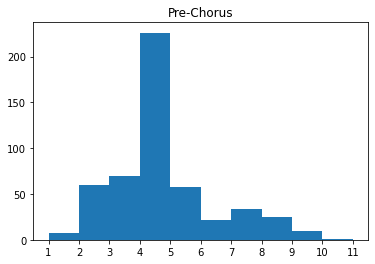

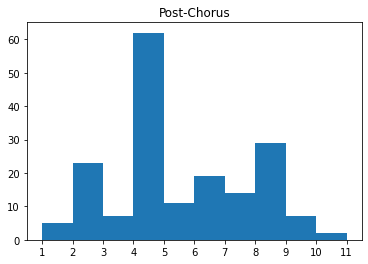

In [18]:
create_histplots(pop_lps)

## Hip Hop Analysis
The following code performs analysis on hip hop artist structures to determine which is the most common using the previously described pie chart function as well as looking into the distribution of number of words/lines in each general structure type across pop songs. See the writing under the previous "Individual Analysis" section for how to go about using this information for songwriting

The structures that were used at least 8 times were the following:
{'Chorus Verse Chorus Verse Chorus': 10,
 'Intro Chorus Verse Chorus Verse Chorus': 30,
 'Intro Chorus Verse Chorus Verse Chorus Verse Chorus': 11,
 'Intro Verse': 8,
 'Intro Verse Chorus Verse Chorus': 17,
 'Intro Verse Chorus Verse Chorus Verse Chorus': 22,
 'Verse Chorus Verse Chorus': 17}


<function matplotlib.pyplot.show(*args, **kw)>

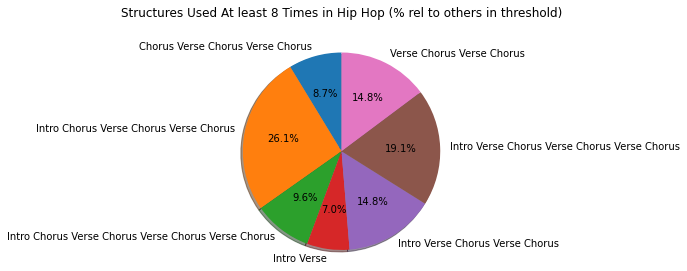

In [19]:
hiphop = artist_types['fem_hiphop'] + artist_types['male_hiphop']

threshold = 8
create_top_thresh_structs_pie(hiphop,threshold)
title = str('Structures Used At least '+str(threshold)+' Times in Hip Hop (% rel to others in threshold)')
plt.title(title,pad= 25.5)
plt.show

In [20]:
target_structs = ['Intro','Chorus','Verse','Bridge','Pre-Chorus','Post-Chorus']
# words per line
hiphop_wpl = get_wpl(hiphop,target_structs) 
# lines per structure
hiphop_lps = get_lps(hiphop,target_structs)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


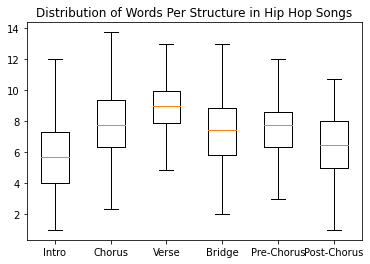

Intro vs Post-Chorus pval= 0.2993527118431839 which is above 0.05 -> fail to reject the null hypothesis

Chorus vs Pre-Chorus pval= 0.11860196289655081 which is above 0.05 -> fail to reject the null hypothesis

Bridge vs Pre-Chorus pval= 0.5703269721490117 which is above 0.05 -> fail to reject the null hypothesis

For all other combinations, the pvalue was less than 0.05, which is evidence to reject the null hypothesis, meaning the difference in mean value between them was statistically signifcant


In [21]:
create_boxplots(hiphop_wpl)
plt.title('Distribution of Words Per Structure in Hip Hop Songs')
plt.show()

mean_ttest(hiphop_wpl, target_structs)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


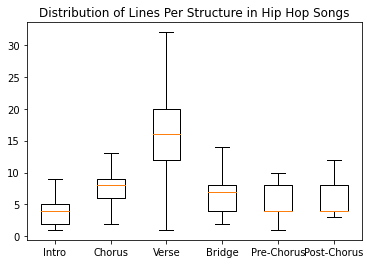

Chorus vs Bridge pval= 0.07982770725857237 which is above 0.05 -> fail to reject the null hypothesis

Pre-Chorus vs Post-Chorus pval= 0.5661425313952423 which is above 0.05 -> fail to reject the null hypothesis

For all other combinations, the pvalue was less than 0.05, which is evidence to reject the null hypothesis, meaning the difference in mean value between them was statistically signifcant


In [22]:
create_boxplots(hiphop_lps)
plt.title('Distribution of Lines Per Structure in Hip Hop Songs')
plt.show()

mean_ttest(hiphop_lps, target_structs)

### Hip Hop Lines Per Structure
The graphs below show that hip hop chrouses, bridges, pre-choruses, post-choruses typically have 4 or 8 lines while hip hop verses typically have 8, 12, or 16 lines. 

For intial songwriting, it would be adivsed to choose lines within these numbers

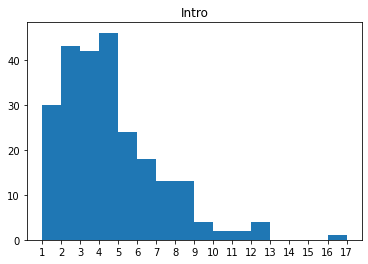

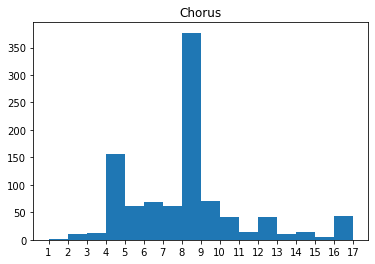

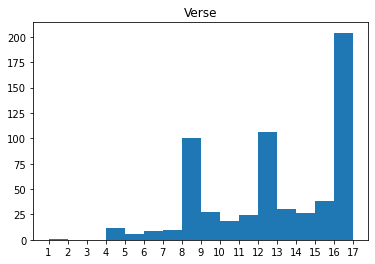

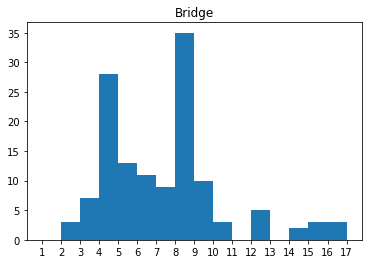

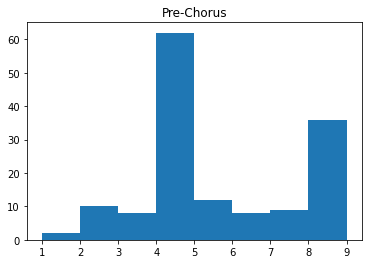

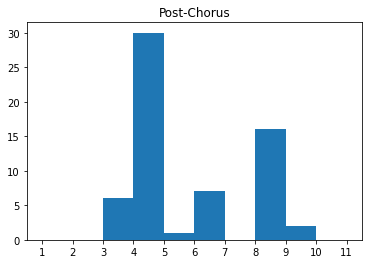

In [23]:
create_histplots(hiphop_lps)

## Male Rock Analysis
The following code performs analysis on male rock artist structures to determine which is the most common using the previously described pie chart function as well as looking into the distribution of number of words/lines in each general structure type across pop songs. See the writing under the previous "Individual Analysis" section for how to go about using this information for songwriting

The structures that were used at least 5 times were the following:
{'Verse Chorus Verse Chorus': 16,
 'Verse Chorus Verse Chorus Bridge Chorus': 10,
 'Verse Chorus Verse Chorus Bridge Verse Chorus': 6,
 'Verse Chorus Verse Chorus Chorus': 12,
 'Verse Chorus Verse Chorus Verse Chorus': 16,
 'Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus': 6,
 'Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus Bridge Chorus': 9,
 'Verse Verse Verse': 5}


<function matplotlib.pyplot.show(*args, **kw)>

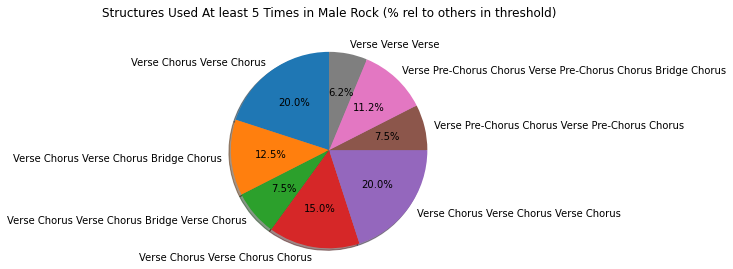

In [24]:
male_rock = artist_types['male_rock']

threshold = 5
create_top_thresh_structs_pie(male_rock,threshold)
title = str('Structures Used At least '+str(threshold)+' Times in Male Rock (% rel to others in threshold)')
plt.title(title,pad= 25.5)
plt.show

In [25]:
target_structs = ['Intro','Chorus','Verse','Bridge','Pre-Chorus','Post-Chorus']
# words per line
male_rock_wpl = get_wpl(male_rock,target_structs) 
# lines per structure
male_rock_lps = get_lps(male_rock,target_structs)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


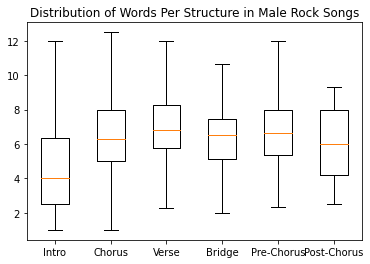

Intro vs Post-Chorus pval= 0.13327973300636065 which is above 0.05 -> fail to reject the null hypothesis

Chorus vs Bridge pval= 0.7742029789314105 which is above 0.05 -> fail to reject the null hypothesis

Chorus vs Pre-Chorus pval= 0.052723465215656844 which is above 0.05 -> fail to reject the null hypothesis

Chorus vs Post-Chorus pval= 0.21132306591649855 which is above 0.05 -> fail to reject the null hypothesis

Verse vs Pre-Chorus pval= 0.5445767174258405 which is above 0.05 -> fail to reject the null hypothesis

Bridge vs Pre-Chorus pval= 0.1818431796392935 which is above 0.05 -> fail to reject the null hypothesis

Bridge vs Post-Chorus pval= 0.17757712869908734 which is above 0.05 -> fail to reject the null hypothesis

Pre-Chorus vs Post-Chorus pval= 0.06084112618750012 which is above 0.05 -> fail to reject the null hypothesis

For all other combinations, the pvalue was less than 0.05, which is evidence to reject the null hypothesis, meaning the difference in mean value between

In [26]:
create_boxplots(male_rock_wpl)
plt.title('Distribution of Words Per Structure in Male Rock Songs')
plt.show()

mean_ttest(male_rock_wpl, target_structs)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


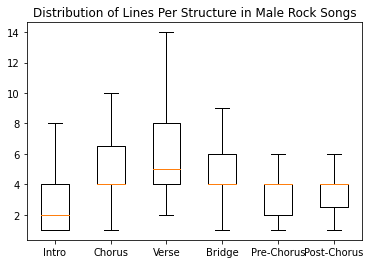

Intro vs Pre-Chorus pval= 0.23361667146417198 which is above 0.05 -> fail to reject the null hypothesis

Intro vs Post-Chorus pval= 0.6171661581588639 which is above 0.05 -> fail to reject the null hypothesis

Chorus vs Bridge pval= 0.4707251310173204 which is above 0.05 -> fail to reject the null hypothesis

Pre-Chorus vs Post-Chorus pval= 0.7007778229918828 which is above 0.05 -> fail to reject the null hypothesis

For all other combinations, the pvalue was less than 0.05, which is evidence to reject the null hypothesis, meaning the difference in mean value between them was statistically signifcant


In [27]:
create_boxplots(male_rock_lps)
plt.title('Distribution of Lines Per Structure in Male Rock Songs')
plt.show()

mean_ttest(male_rock_lps, target_structs)

### Rock Lines Per Structure
The graphs below show that most rock structures have 4 lines in them (less commonly 8 in a verse). 
For intial songwriting, it would be adivsed to choose lines within these numbers

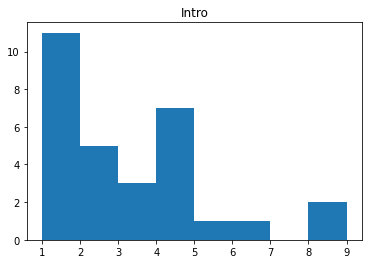

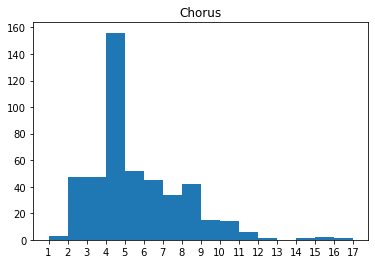

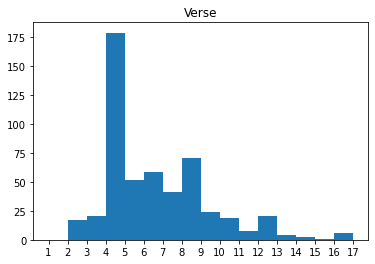

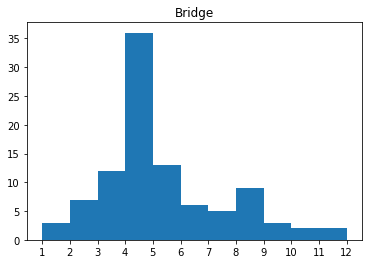

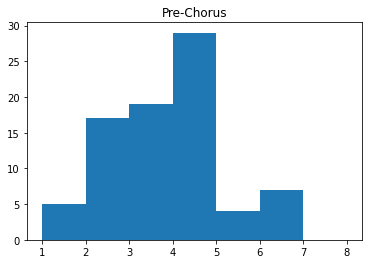

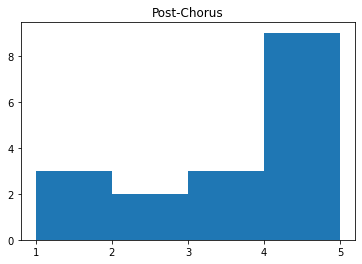

In [28]:
create_histplots(male_rock_lps)

# Comparative Genre Analysis
The following code performs analysis to see how different structures in the different genres compare to each other. This information will likely not be paricularly useful for songwriting because it would be a better idea to look at an individual genre to model a structure off of than to look at a combination of differnet genres. As such, this information is more for understanding differences between genres with respect to lines and words in different structures.

### Complete Pie Chart
This pie chart uses all artists in every genre and plots a pie chart of structures used at least 20 times. It seems that certain structures are conserved across genres to some extent

The structures that were used at least 20 times were the following:
{'Intro Chorus Verse Chorus Verse Chorus': 30,
 'Intro Verse Chorus Verse Chorus Verse Chorus': 31,
 'Intro Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus Bridge Chorus': 24,
 'Verse Chorus Verse Chorus': 42,
 'Verse Chorus Verse Chorus Bridge Chorus': 65,
 'Verse Chorus Verse Chorus Chorus': 20,
 'Verse Chorus Verse Chorus Verse Chorus': 29,
 'Verse Pre-Chorus Chorus Verse Pre-Chorus Chorus Bridge Chorus': 89}


<function matplotlib.pyplot.show(*args, **kw)>

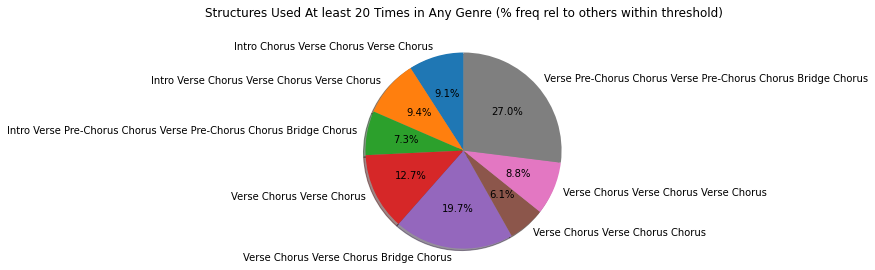

In [29]:
all_artists = []
for key in artist_types.keys():
    all_artists = all_artists + artist_types[key]

threshold = 20
create_top_thresh_structs_pie(all_artists,threshold)
title = str('Structures Used At least '+str(threshold)+' Times in Any Genre (% freq rel to others within threshold)')
plt.title(title,pad= 25.5)
plt.show

#### All Structure Analysis
The following computes a dataframe that will store all information pertaining to words and lines that structure methods calculate. This dataframe will be used to visualize how the different genres compare with respect to statistics pertaining words and lines.

In [30]:
target_structs = ['Intro','Chorus','Verse','Bridge','Pre-Chorus','Post-Chorus']
struct_data = []

for artist in all_artists:
    for songs in artist.songs:
        for struct in songs.structure:
            if struct.type in target_structs:
                # makes classification something liike hiphop_Verse
                s_classification = artist.category[artist.category.find('_')+1:] + '_' + struct.type
                struct_data.append(struct.get_full_analysis() + [s_classification])

struct_df = pd.DataFrame(struct_data, columns = ['words','lines','repeat words','repeat lines','std(words per line)',\
                        'mean(word length)','std(word length)','classification'])
struct_df

,words,lines,repeat words,repeat lines,std(words per line),mean(word length),std(word length),classification
0,44,8,3,0,1.118034,3.840909,1.718128,pop_Verse
1,44,9,18,0,0.737028,3.477273,1.529834,pop_Pre-Chorus
2,33,8,22,4,1.165922,3.878788,1.409009,pop_Chorus
3,49,8,8,0,2.027159,3.755102,1.790344,pop_Verse
4,53,8,21,0,1.653595,4.075472,1.635099,pop_Pre-Chorus
...,...,...,...,...,...,...,...,...
6980,24,2,0,0,2.000000,4.333333,2.460804,rock_Verse
6981,28,3,2,0,2.494438,4.035714,1.782497,rock_Pre-Chorus
6982,46,6,24,2,1.247219,4.217391,1.828673,rock_Chorus
6983,32,4,6,0,3.162278,4.000000,1.713914,rock_Pre-Chorus


#### Groupings
The following code groups the dataframe into verses and choruses and then a single dataframe that takes the mean value of all statistics that is outputted

In [31]:
verse_structs = ['hiphop_Verse','rock_Verse',\
                  'pop_Verse',]
chorus_structs = ['hiphop_Chorus','pop_Chorus','rock_Chorus']

# df that only stores verse structure information
verse_df = struct_df.loc[struct_df['classification'].isin(verse_structs)]
chorus_df = struct_df.loc[struct_df['classification'].isin(chorus_structs)]
# df that only stores chorus structure information

avg_grouped_df = struct_df.groupby('classification').mean().reset_index()

avg_verse_df = avg_grouped_df[avg_grouped_df['classification'].isin(verse_structs)]
avg_chorus_df = avg_grouped_df[avg_grouped_df['classification'].isin(chorus_structs)]

avg_grouped_df

,classification,words,lines,repeat words,repeat lines,std(words per line),mean(word length),std(word length)
0,hiphop_Bridge,54.820896,7.328358,28.335821,1.753731,1.681215,3.768631,1.555628
1,hiphop_Chorus,60.947211,7.881474,32.974104,1.908367,1.800016,3.765553,1.654131
2,hiphop_Intro,25.695473,4.156379,9.012346,0.358025,1.920949,4.087149,1.506488
3,hiphop_Post-Chorus,36.079365,5.444444,20.238095,1.555556,1.364233,4.605703,1.755707
4,hiphop_Pre-Chorus,38.753333,5.260000,14.473333,0.646667,1.490206,3.791633,1.659162
5,hiphop_Verse,158.318841,17.687371,59.851967,0.098344,2.213984,3.852503,1.825051
6,pop_Bridge,41.753289,6.078947,17.759868,1.003289,1.689530,3.789990,1.670889
7,pop_Chorus,54.113861,7.773927,26.965347,1.677393,1.886815,3.808962,1.739052
8,pop_Intro,21.392157,3.754902,8.715686,0.578431,1.179088,3.881489,1.374035
9,pop_Post-Chorus,29.700000,5.083333,17.800000,1.755556,1.449310,4.184722,1.777343


## Clustering Plots
The following plots analyze different statistics about the words and lines in songs across the genres and shows labels where different structures within a category appear on the chart. This can qualitatively be used to determine differences between genres. These differences are quantitatively analyzed using t-tests with a null hypothesis of idential population means

### Verse Lines vs. Words:

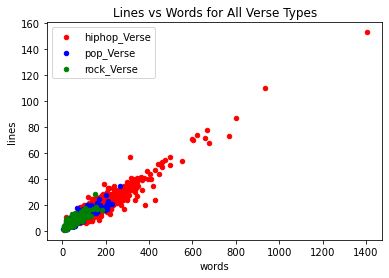

In [32]:
fig, ax = plt.subplots()
grouped = verse_df[['words','lines','classification']].groupby('classification')
colors = {'hiphop_Verse' : 'red','pop_Verse' : 'blue','rock_Verse' : 'green'}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='words', y='lines', label=key, color = colors[key])
plt.legend()
plt.title('Lines vs Words for All Verse Types')
plt.show()

The above plot shows that there are signifcant differences between lines and words between hip hop verses and pop/rock verses. The graph below quantifies this showing that on average hip hop verses have about 160 words whereas pop and rock verses have about 50 and 45 respectively. The analysis also concludes that differences between all three genres are statistically signifcant, suggesting that the ordering for average number of words in a verse is hip hop >> pop > rock

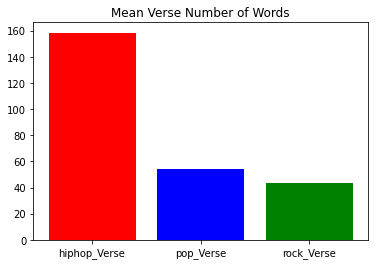

For all combinations, the pvalue was less than 0.05, which means the the differnce between means for all categories was statistically signifcant.


In [33]:
values_dict = {'hiphop_Verse':[],'pop_Verse':[],'rock_Verse':[]}
for key in values_dict.keys():
    values_dict[key] = np.array(verse_df.loc[verse_df['classification'] == key]['words'])

verse_means = [np.mean(values_dict['hiphop_Verse']),np.mean(values_dict['pop_Verse']),\
              np.mean(values_dict['rock_Verse'])]

plt.bar(values_dict.keys(), verse_means, color = list(colors.values()))
plt.title('Mean Verse Number of Words')
plt.show()
mean_ttest(values_dict, list(values_dict.keys()))

### Verse Standard Deviation of Word Length vs. Mean Word Length:

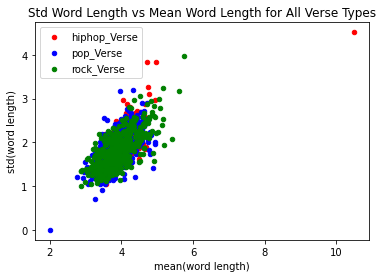

In [34]:
fig, ax = plt.subplots()
grouped = verse_df[['mean(word length)','std(word length)','classification']].groupby('classification')
colors = {'hiphop_Verse' : 'red','pop_Verse' : 'blue','rock_Verse' : 'green'}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='mean(word length)', y='std(word length)', label=key, color = colors[key])
plt.legend()
plt.title('Std Word Length vs Mean Word Length for All Verse Types')
plt.show()

The above plot qualitatively indicates that the genre verses are relatively similar with respect to word length in their structures, with maybe a few songs in rock having higher mean word length and some rap songs having higher standard deviation of word length (very few for both cases). The graphs below suggest that the only statistically significant difference between word lengths was that rock verses have higher word lengths on average, but the difference betwen averages is <0.1, so this distinction is not too meaningful subjectively.

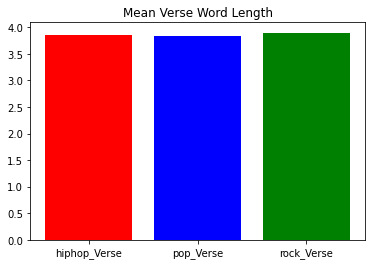

hiphop_Verse vs pop_Verse pval= 0.34586872044198913 which is above 0.05 -> fail to reject the null hypothesis

For all other combinations, the pvalue was less than 0.05, which is evidence to reject the null hypothesis, meaning the difference in mean value between them was statistically signifcant


In [35]:
values_dict = {'hiphop_Verse':[],'pop_Verse':[],'rock_Verse':[]}
for key in values_dict.keys():
    values_dict[key] = np.array(verse_df.loc[verse_df['classification'] ==\
                                             key]['mean(word length)'])

verse_means = [np.mean(values_dict['hiphop_Verse']),np.mean(values_dict['pop_Verse']),\
              np.mean(values_dict['rock_Verse'])]

plt.bar(values_dict.keys(), verse_means,color = list(colors.values()))
plt.title('Mean Verse Word Length')
plt.show()
mean_ttest(values_dict, list(values_dict.keys()))

### Chorus Lines vs. Words:

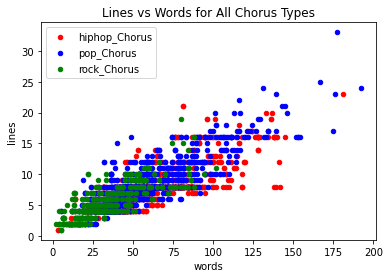

In [36]:
fig, ax = plt.subplots()
grouped = chorus_df[['words','lines','classification']].groupby('classification')
colors = {'hiphop_Chorus' : 'red','pop_Chorus' : 'blue','rock_Chorus' : 'green'}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='words', y='lines', label=key, color = colors[key])
plt.legend()
plt.title('Lines vs Words for All Chorus Types')
plt.show()

The above plot suggests that there are notable differences between lines and words between hip hop verses and pop/rock choruses with hip hop and pop choruses having on average more lines/words than rock choruses. This is similar to the finding in individual analysis where rock choruses mostly only had 4 lines where pop and hip hop had 4 or 8 typically. The graph below quantifies this showing that on average hip hop chorus has twice as many words as the average rock chorus, and the average pop chorus has a little less than twice as much on average. It also shows that hip hop choruses on overage have more words than pop choruses. All of these differences were statistically signficant with a pvalue of 0.05.

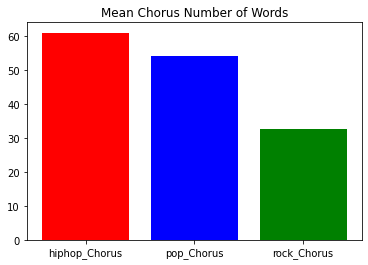

For all combinations, the pvalue was less than 0.05, which means the the differnce between means for all categories was statistically signifcant.


In [37]:
values_dict = {'hiphop_Chorus':[],'pop_Chorus':[],'rock_Chorus':[]}
for key in values_dict.keys():
    values_dict[key] = np.array(chorus_df.loc[chorus_df['classification'] == key]['words'])

chorus_means = [np.mean(values_dict['hiphop_Chorus']),np.mean(values_dict['pop_Chorus']),\
              np.mean(values_dict['rock_Chorus'])]

plt.bar(values_dict.keys(), chorus_means, color = list(colors.values()))
plt.title('Mean Chorus Number of Words')
plt.show()
mean_ttest(values_dict, list(values_dict.keys()))

### Chorus Standard Deviation of Word Length vs. Mean Word Length:

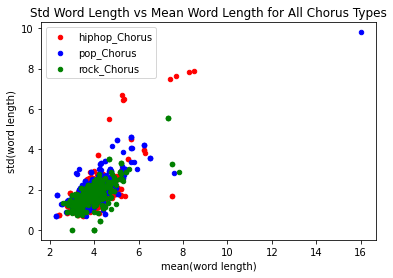

In [38]:
fig, ax = plt.subplots()
grouped = chorus_df[['mean(word length)','std(word length)','classification']].groupby('classification')
colors = {'hiphop_Chorus' : 'red','pop_Chorus' : 'blue','rock_Chorus' : 'green'}
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='mean(word length)', y='std(word length)', label=key, color = colors[key])
# plt.xticks(np.arange(min(train_mus),max(train_mus)+1,1))
plt.legend()
plt.title('Std Word Length vs Mean Word Length for All Chorus Types')
plt.show()


The above plot qualitatively indicates that the genre choruses are relatively similar with respect to word length in their structures, with maybe a few songs in rock having higher mean word length and some rap songs having higher standard deviation of word length (very few for both cases). The graphs below suggest that the only statistically significant difference between word lengths was that rock verses have higher word lengths on average, but the difference betwen averages is <0.1, so this distinction is not too meaningful subjectively.

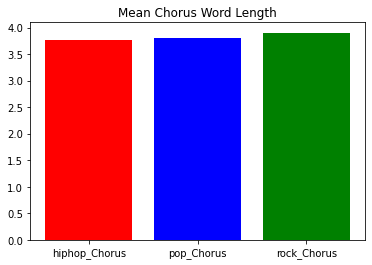

hiphop_Chorus vs pop_Chorus pval= 0.08806203963734707 which is above 0.05 -> fail to reject the null hypothesis

For all other combinations, the pvalue was less than 0.05, which is evidence to reject the null hypothesis, meaning the difference in mean value between them was statistically signifcant


In [39]:
values_dict = {'hiphop_Chorus':[],'pop_Chorus':[],'rock_Chorus':[]}
for key in values_dict.keys():
    values_dict[key] = np.array(chorus_df.loc[chorus_df['classification'] ==\
                                              key]['mean(word length)'])

chorus_means = [np.mean(values_dict['hiphop_Chorus']),np.mean(values_dict['pop_Chorus']),\
              np.mean(values_dict['rock_Chorus'])]

plt.bar(values_dict.keys(), chorus_means, color = list(colors.values()))
plt.title('Mean Chorus Word Length')
plt.show()
mean_ttest(values_dict, list(values_dict.keys()))

# Conclusions
The code was able to successfully identify the most popular song structures in the different genres as well as investigate the line and word composition of those structures. This information will be useful to songwriters who seek to structure their songs according to genre norms, which is recommended for beginning songwriters. 

The code also saw noticeable structural differences across genres, with hip hop verses and choruses on average having more words. There were other smaller statistically signifcant differences, but it was also shown that the average word length was fairly similar across genres. I personally was expecting hip hop to have the highest average word length, but it was found that rock actually had a statistically significant higher average word length compared to hip hop and pop, even though it was very small.